In [1]:
import torch
import torchvision

### Load Data

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

from PIL import Image
import os
import os.path
import re

In [3]:
data_dir = "../data/"
re_exp = "(.+)-.+-.+."
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [4]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]


def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir, re_expression, match_group=1):
    images = sorted(os.listdir(dir))
    classes = [re.match(re_expression, file_name).group(match_group) for file_name in images]
    
    classes_distinct = list(set(classes))
    class_to_idx = {classes_distinct[i]: i for i in range(len(classes_distinct))}
    
    target = [*map(class_to_idx.get, classes)]
    
    return classes, class_to_idx, list(zip(images, target))

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')


def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [5]:
class ImageFolderDiscrete(torch.utils.data.Dataset):
    """A data loader where the images are arranged in this way : ::
    
    root/{class}-{index}-{price}.jpg
    
    Args:
        root (string): Root directory path
        transform (callable, optional): a function transform
        target_transform (callable, optional)
        loader (callable, optional)
        
    Attributes:
        classes (list): List of the class names 
        class_to_idx (dict): Dict with items (class_name, class_index)
        imgs (list): List of (image_path, class_index) tuples 
    """
    
    def __init__(self, root, re_expression, transform=None, target_transform=None, loader=default_loader):
        classes, class_to_idx, imgs = make_dataset(root, re_expression)
        
        if len(imgs) == 0:
            raise(RuntimeError("Found 0 images in subfolders of: " + root + "\n"
                               "Supported image extensions are: " + ",".join(IMG_EXTENSIONS)))
            
        self.root = root 
        self.imgs = imgs 
        self.classes = classes 
        self.class_to_idx = class_to_idx 
        self.transform = transform 
        self.target_transform = target_transform
        self.loader = loader 
        
        
    def __getitem__(self, index):
        """
        """
        path, target = self.imgs[index]
        img = self.loader(os.path.join(self.root, path))
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
            
        return img, target
        
    def __len__(self):
        return len(self.imgs)

In [6]:
ifd = ImageFolderDiscrete(data_dir, re_exp, data_transforms)
classes_dict = dict(map(reversed, ifd.class_to_idx.items()))

In [7]:
num_classes = len(classes_dict)

In [8]:
train_count = int(0.8 * len(ifd))
val_count = len(ifd) - train_count
train_dataset, val_dataset = torch.utils.data.random_split(ifd, (train_count, val_count))

In [9]:
BATCH_SIZE = 128
NUM_WORKER = 4

In [10]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)
val_dataset_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKER)

In [11]:
dataloaders = {"train": train_dataset_loader, "val": val_dataset_loader}
dataset_sizes = {"train": len(train_dataset_loader), "val": len(val_dataset_loader)}

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

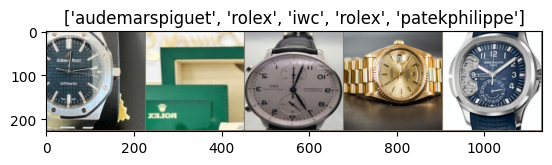

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataset_loader))

inputs = inputs[0:5]
classes = classes[0:5]

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes_dict[x.item()] for x in classes])

In [22]:
train_dataset[0][0].size(0)

3

## Neural Network

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {classes_dict[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
model_ft = models.resnet18(weights=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 13.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, num_classes)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/home/ctyler/python-envs/stack-analyzer/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 190.2441 Acc: 74.3077
val Loss: 168.6442 Acc: 50.0000
Epoch 1/49
----------
train Loss: 190.0096 Acc: 74.8462
val Loss: 168.4522 Acc: 53.5000
Epoch 2/49
----------
train Loss: 190.7230 Acc: 74.0000
val Loss: 167.0706 Acc: 52.7500
Epoch 3/49
----------
train Loss: 191.8600 Acc: 71.9231
val Loss: 170.8544 Acc: 53.2500
Epoch 4/49
----------
train Loss: 191.7401 Acc: 72.4615
val Loss: 168.7662 Acc: 50.7500
Epoch 5/49
----------
train Loss: 190.9317 Acc: 73.4615
val Loss: 165.8852 Acc: 55.2500
Epoch 6/49
----------
train Loss: 191.2425 Acc: 75.1538
val Loss: 165.2001 Acc: 54.5000
Epoch 7/49
----------
train Loss: 191.2193 Acc: 73.8462
val Loss: 167.5254 Acc: 53.2500
Epoch 8/49
----------
train Loss: 189.1351 Acc: 74.0769
val Loss: 170.0989 Acc: 52.7500
Epoch 9/49
----------
train Loss: 190.8185 Acc: 75.5385
val Loss: 167.1093 Acc: 54.0000
Epoch 10/49
----------
train Loss: 191.5058 Acc: 73.6154
val Loss: 166.9850 Acc: 52.5000
Epoch 11/49
----------
train Lo

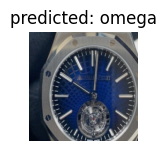

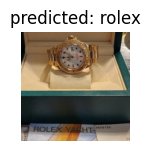

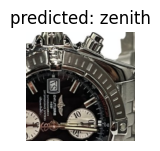

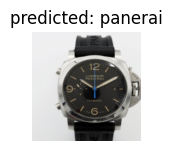

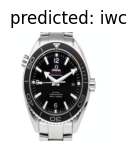

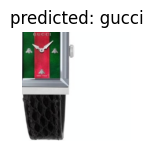

In [23]:
visualize_model(model_ft)

In [24]:
model_conv = torchvision.models.resnet18(weights=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, num_classes)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 339.0697 Acc: 8.9231
val Loss: 264.5696 Acc: 12.0000
Epoch 1/24
----------
train Loss: 321.2848 Acc: 14.3077
val Loss: 258.5031 Acc: 12.5000
Epoch 2/24
----------
train Loss: 306.2626 Acc: 22.3077
val Loss: 244.2296 Acc: 20.0000
Epoch 3/24
----------
train Loss: 294.9175 Acc: 29.6923
val Loss: 235.9273 Acc: 25.2500
Epoch 4/24
----------
train Loss: 285.4516 Acc: 36.2308
val Loss: 231.0209 Acc: 28.5000
Epoch 5/24
----------
train Loss: 274.3803 Acc: 41.2308
val Loss: 220.5764 Acc: 33.7500
Epoch 6/24
----------
train Loss: 266.3137 Acc: 45.3846
val Loss: 216.6211 Acc: 36.7500
Epoch 7/24
----------
train Loss: 261.2821 Acc: 49.0000
val Loss: 216.0038 Acc: 35.2500
Epoch 8/24
----------
train Loss: 260.7234 Acc: 50.4615
val Loss: 214.3664 Acc: 39.2500
Epoch 9/24
----------
train Loss: 260.4875 Acc: 50.1538
val Loss: 215.8308 Acc: 32.0000
Epoch 10/24
----------
train Loss: 259.7414 Acc: 49.7692
val Loss: 212.0567 Acc: 39.7500
Epoch 11/24
----------
train Los

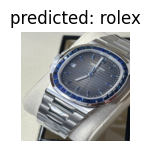

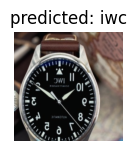

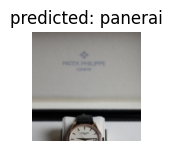

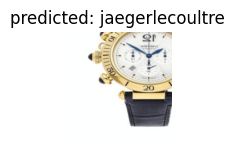

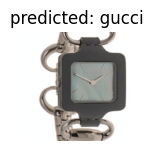

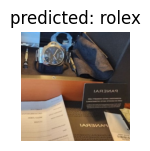

In [26]:
visualize_model(model_conv)

plt.ioff()
plt.show()

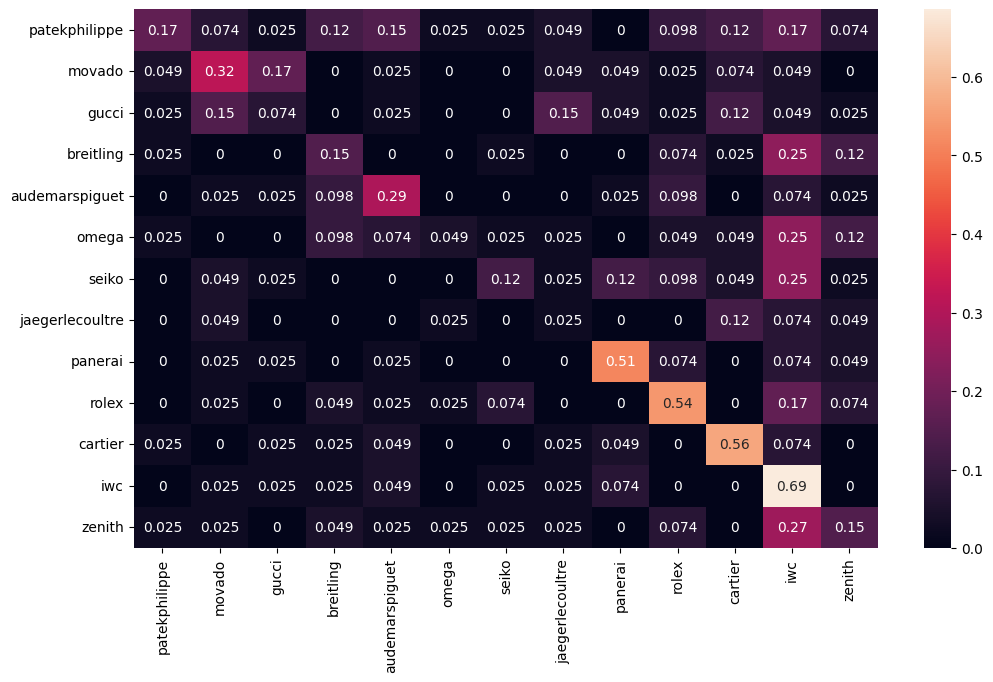

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in val_dataset_loader:
    
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_conv(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = classes_dict.values()

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')
plt.show()

In [41]:
torch.save(model_conv.state_dict(), "../data/model/classifier.pth")